## Training Neural Networks

**loss function**
<img src='https://user-images.githubusercontent.com/24764528/50548756-4ed98d80-0c78-11e9-8ce2-ba646fd7e21b.png' width='400px'></p>
where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

Minimize loss using gradient descent.

## Backpropagation
<img src='https://user-images.githubusercontent.com/24764528/40543407-d5014d00-6041-11e8-8c77-9524d8922995.gif' width='400px'></p>

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

We update our weights using this gradient with some learning rate $\alpha$.

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$


## Losses in PyTorch
 PyTorch provides losses such as the cross-entropy loss **(nn.CrossEntropyLoss)** assigned to **criterion**.
 
 **Note**
 
 we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the logits or scores. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one. It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [2]:
# Model using raw logits and nn.CrossEntropyLoss
model = nn.Sequential(
                        nn.Linear(784,128),
                        nn.ReLU(),
                        nn.Linear(128,64),
                        nn.ReLU(),
                        nn.Linear(64,10)
                    )

# Define Loss
criterion = nn.CrossEntropyLoss()

# Get your data
images , labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0],-1)

# Forward pass get your logits
logits = model(images)

# Calculate the loss with logits and labels
loss = criterion(logits,labels)

print(loss)

tensor(2.3596, grad_fn=<NllLossBackward>)


### LogSoftmax Output 
it's more convenient to build the model with a **log-softmax** output using **nn.LogSoftmax** or **F.log_softmax** .Get the actual probabilities by taking the exponential torch.exp(output). 
With a log-softmax output, you want to use the **negative log likelihood loss, nn.NLLLoss**.

Note that for nn.LogSoftmax and F.log_softmax you'll need to set the dim keyword argument appropriately. dim=0 calculates softmax across the rows, so each column sums to 1, while dim=1 calculates across the columns so each row sums to 1. Think about what you want the output to be and choose dim appropriately.

In [3]:
# Model using nn.LogSOftmax with error function nn.NLLLoss
model = nn.Sequential(
                        nn.Linear(784,128),
                        nn.ReLU(),
                        nn.Linear(128,64),
                        nn.ReLU(),
                        nn.Linear(64,10),
                        nn.LogSoftmax(dim =1)
                    )

# Define Loss
criterion = nn.NLLLoss()

# Get your data
images , labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0],-1)

# Forward pass get your logits
log_probability = model(images)

# Calculate the loss with logits and labels
loss = criterion(log_probability,labels)

print(loss)

tensor(2.2903, grad_fn=<NllLossBackward>)



## Autograd

- To perform Backpropagation
- To automatically calculating the gradients of tensors
- calculate the gradients of all our parameters with respect to the loss
- Autograd works by keeping track of operations performed on tensors
- To make sure PyTorch keeps track of operations on a tensor use **requires_grad = True on a tensor**
- At any time do  **x.requires_grad_(True)**
- **x.grad** tells value of gradient
- **c.grad_fn** shows functin that generated this variable
- you can turn on or off gradients altogether with **torch.set_grad_enabled(True|False)**.
- You can turn off gradients for a block of code with the torch.no_grad()

In [4]:
# Autograd usage Example
# Autograd track tensors for this set requires_grad = true
x = torch.randn(2,2,requires_grad = True)
y = x ** 2
print("x=", x)
print("y=", y)
# grad_fn shows the function that generated this variable
print(y.grad_fn)
z = y.mean()

# To show gradient 
print(x.grad)
# To Calculate gradient 
z.backward()
# Comparing output came and gradient output
print(x.grad)
print(x/2)


x= tensor([[-1.0055, -0.4734],
        [ 0.3397,  1.2363]], requires_grad=True)
y= tensor([[1.0111, 0.2241],
        [0.1154, 1.5285]], grad_fn=<PowBackward0>)
None
tensor([[-0.5028, -0.2367],
        [ 0.1699,  0.6182]])
tensor([[-0.5028, -0.2367],
        [ 0.1699,  0.6182]], grad_fn=<DivBackward0>)


Gradient of x



## Loss and Autograd together

- When we create a network with PyTorch, all of the parameters are initialized with requires_grad = True.

- These gradients are used to update the weights with gradient descent.

In [5]:
# Autograd with Loss to Calculate Gradients

model = nn.Sequential(
                        nn.Linear(784,128),
                        nn.ReLU(),
                        nn.Linear(128,64),
                        nn.ReLU(),
                        nn.Linear(64,10),
                        nn.Softmax(dim=1)
                        )

criterion = nn.NLLLoss()

# Get your data
images , labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0],-1)

loss_prob = model(images)
loss = criterion(loss_prob, labels)

#Checking gradient of first layer
print(model[0].weight.grad)

#Generating weights
loss.backward()

#Output of gradients of first layer
print(model[0].weight.grad)
                

None
tensor([[ 9.3826e-06,  9.3826e-06,  9.3826e-06,  ...,  9.3826e-06,
          9.3826e-06,  9.3826e-06],
        [ 5.9414e-05,  5.9414e-05,  5.9414e-05,  ...,  5.9414e-05,
          5.9414e-05,  5.9414e-05],
        [-2.9772e-04, -2.9772e-04, -2.9772e-04,  ..., -2.9772e-04,
         -2.9772e-04, -2.9772e-04],
        ...,
        [ 1.1906e-04,  1.1906e-04,  1.1906e-04,  ...,  1.1906e-04,
          1.1906e-04,  1.1906e-04],
        [ 4.3542e-06,  4.3542e-06,  4.3542e-06,  ...,  4.3542e-06,
          4.3542e-06,  4.3542e-06],
        [ 2.4861e-04,  2.4861e-04,  2.4861e-04,  ...,  2.4861e-04,
          2.4861e-04,  2.4861e-04]])



## Training the network
- **optimizer** that we'll use to update the weights with the gradients. We get these from **PyTorch's optim** package.

### The general process with PyTorch:

- Make a **forward pass** through the network
- Use the network **output** to calculate the loss
- Perform a **backward pass** through the network with loss.backward() to calculate the gradients
- Take a step with the optimizer to **update the weights**

-**note**
optimizer.zero_grad(). When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.


In [6]:
# Pytorch Optim is used for updating weights 
from torch import optim

# Optimizers require the parameters to optiize and learing rate , SGD means stochastic Gradeint DEscent
optimizer = optim.SGD(model.parameters(), lr = 0.01)


In [7]:
print('Initial weights ---' , model[0].weight)
images , lables = next(iter(trainloader))
images = images.view(images.shape[0],-1)

# Clear the Gradients , because gradients are accumulated from previous model and never erased
optimizer.zero_grad()

# Forward Pass
output = model.forward(images)

# Loss calculation 
loss = criterion(output , labels)

# Backward pass to calculate gradients
loss.backward()

print('Gradient - ', model[0].weight.grad)


Initial weights --- Parameter containing:
tensor([[ 0.0063, -0.0339, -0.0045,  ...,  0.0325, -0.0283,  0.0308],
        [-0.0283,  0.0074, -0.0045,  ...,  0.0283,  0.0225,  0.0079],
        [ 0.0176, -0.0110,  0.0029,  ...,  0.0030,  0.0145, -0.0203],
        ...,
        [-0.0314, -0.0076, -0.0015,  ..., -0.0009, -0.0289, -0.0018],
        [ 0.0331,  0.0221, -0.0091,  ..., -0.0302, -0.0179,  0.0240],
        [-0.0171, -0.0100,  0.0104,  ...,  0.0086, -0.0341,  0.0174]],
       requires_grad=True)
Gradient -  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.1316e-05, -9.1316e-05, -9.1316e-05,  ..., -9.1316e-05,
         -9.1316e-05, -9.1316e-05],
        [-9.7919e-05, -9.7919e-05, -9.7919e-05,  ..., -9.7919e-05,
         -9.7919e-05, -9.7919e-05],
        ...,
        [ 1.0838e-04,  1.0838e-04,  1.0838e-04,  ...,  1.0838e-04,
          1.0838e-04,  1.0838e-04],
        [ 2.6717e-05,  2.6717e-05,  2.6717e-05,  ...,  2.671

In [8]:
# Updat step and weights updated
optimizer.step()
print('updated weights --' , model[0].weight)

updated weights -- Parameter containing:
tensor([[ 0.0063, -0.0339, -0.0045,  ...,  0.0325, -0.0283,  0.0308],
        [-0.0283,  0.0074, -0.0045,  ...,  0.0283,  0.0225,  0.0079],
        [ 0.0176, -0.0110,  0.0029,  ...,  0.0030,  0.0145, -0.0203],
        ...,
        [-0.0314, -0.0076, -0.0015,  ..., -0.0009, -0.0289, -0.0018],
        [ 0.0331,  0.0221, -0.0091,  ..., -0.0302, -0.0179,  0.0240],
        [-0.0171, -0.0100,  0.0104,  ...,  0.0086, -0.0341,  0.0174]],
       requires_grad=True)


## SOLUTION  

- Algorithm into a loop so we can go through all the images. one pass through the entire dataset is called an **epoch**. So here we're going to loop through trainloader to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

In [9]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            optimizer.zero_grad()

            # TODO: Training pass

            loss = criterion(model.forward(images), labels)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        
        else:
            print(f"Training loss: {running_loss/len(trainloader)}")


Training loss: 1.9752200104788677
Training loss: 0.9168159902604149
Training loss: 0.5470624945438238
Training loss: 0.44533174986968926
Training loss: 0.39591231764252505


tensor([[8.0635e-06, 1.4671e-03, 2.3314e-02, 3.3154e-02, 1.8511e-03, 3.6528e-04,
         6.7920e-06, 6.3255e-01, 1.8814e-02, 2.8847e-01]])


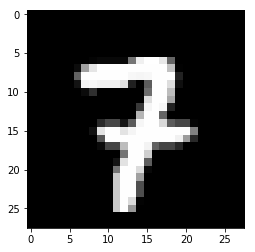

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

    
# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
print(ps)
